## Automated Fake News Detection and Reliable News Source Recommendation

### Objectives

- The program should accept links as input and extract the entire title and content from those links with at least 95% accuracy in capturing the text as compared to the original webpage. 

- The program should achieve a minimum accuracy rate of 80% when the program is identifying fake news articles. 

- The program  should provide an analysis and suggestion within 10 seconds of each article link it is fed. 

- At least 90% of the suggested alternative news sources should be verified as reliable by recognized media watchdogs.


### Setup and Libraries Installation

In [1]:
# Load libraries

import re
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

### Data Collection and Web Scraping

In [2]:
# Download the stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
bbc_data = pd.read_csv('bbc_articles.csv')

In [4]:
bbc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775 entries, 0 to 774
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      775 non-null    object
 1   title    775 non-null    object
 2   content  775 non-null    object
dtypes: object(3)
memory usage: 18.3+ KB


In [5]:
fake_news = pd.read_csv('fake-news.csv')

fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Site name     327 non-null    object
 1   Type of site  327 non-null    object
dtypes: object(2)
memory usage: 5.2+ KB


In [6]:
fake_news_2 = pd.read_excel('fake.xlsx')

fake_news_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Domain  402 non-null    object
 1   Notes   224 non-null    object
dtypes: object(2)
memory usage: 6.5+ KB


In [7]:
# Preprocessing

fake_news.rename(columns = {'Site name': 'url'}, inplace = True)

fake_news_2.rename(columns = {'Domain': 'url'}, inplace = True)

fake_news_2.rename(columns = {'Notes': 'content'}, inplace = True)

fake_news_2.fillna('Fake News', inplace = True)

fake_news.rename(columns = {'Type of site': 'content'}, inplace = True)

In [8]:
fake_news_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      406 non-null    object
 1   content  406 non-null    object
dtypes: object(2)
memory usage: 6.5+ KB


In [9]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      327 non-null    object
 1   content  327 non-null    object
dtypes: object(2)
memory usage: 5.2+ KB


In [10]:
# Concatenate the two fake news datasets and drop Status, notes columns

fake_news = pd.concat([fake_news, fake_news_2], ignore_index = True)

fake_news['label'] = 0 # Fake news

bbc_data['label'] = 1 # Real news

# Since we do not have titles for fake news, we'll leave them empty
fake_news['title'] = ''

# Select only the relevant columns
fake_news = fake_news[['url', 'title', 'content', 'label']]

# Select only the relevant columns from BBC news
bbc_news = bbc_data[['url', 'title', 'content', 'label']]

### Text Preprocessing

In [11]:
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Tokenize text
    tokens = word_tokenize(text.lower())
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    
    return ' '.join(tokens)

In [12]:
# Add a new column to store the preprocessed text
fake_news['processed_content'] = fake_news['content'].apply(preprocess_text)

bbc_news['processed_content'] = bbc_news['content'].apply(preprocess_text)

In [13]:
# Combine the two datasets
combined_data = pd.concat([fake_news, bbc_news], ignore_index = True)

combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508 entries, 0 to 1507
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   url                1508 non-null   object
 1   title              1508 non-null   object
 2   content            1508 non-null   object
 3   label              1508 non-null   int64 
 4   processed_content  1508 non-null   object
dtypes: int64(1), object(4)
memory usage: 59.0+ KB


<Axes: xlabel='label'>

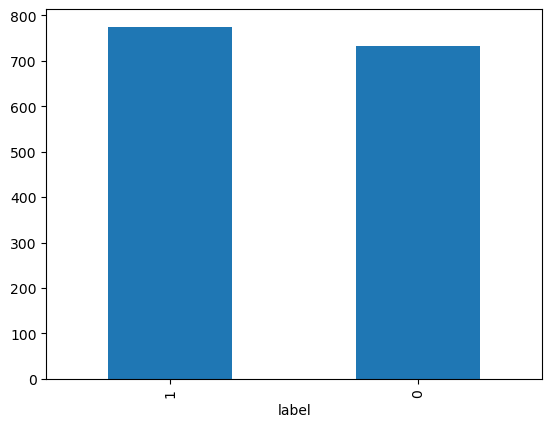

In [14]:
# Plot the distribution of the labels
combined_data['label'].value_counts().plot(kind = 'bar')

### Model Training and Evaluation

In [15]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508 entries, 0 to 1507
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   url                1508 non-null   object
 1   title              1508 non-null   object
 2   content            1508 non-null   object
 3   label              1508 non-null   int64 
 4   processed_content  1508 non-null   object
dtypes: int64(1), object(4)
memory usage: 59.0+ KB


In [36]:
# Vectorize text using TF-IDF

vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(combined_data['processed_content']).toarray()

y = combined_data['label']

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Epoch 1/5
19/19 [==============================] - 0s 10ms/step - loss: 0.4522 - accuracy: 0.8400 - val_loss: 0.1728 - val_accuracy: 0.9702
Epoch 2/5
19/19 [==============================] - 0s 4ms/step - loss: 0.0674 - accuracy: 0.9900 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 3/5
19/19 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 0.9967 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 4/5
19/19 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 5/5
19/19 [==============================] - 0s 4ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Confusion Matrix for Logistic Regression:
[[143   4]
 [  0 155]]

Logistic Regression Accuracy: 0.9867549668874173
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       147
           1       0.97      1.00    

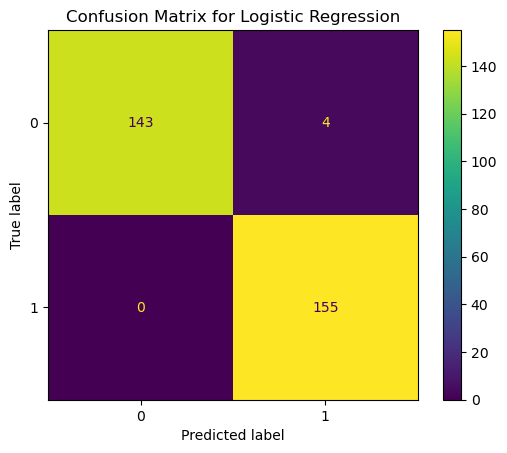

Confusion Matrix for Random Forest:
[[147   0]
 [  0 155]]

Random Forest Accuracy: 1.0
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       1.00      1.00      1.00       155

    accuracy                           1.00       302
   macro avg       1.00      1.00      1.00       302
weighted avg       1.00      1.00      1.00       302



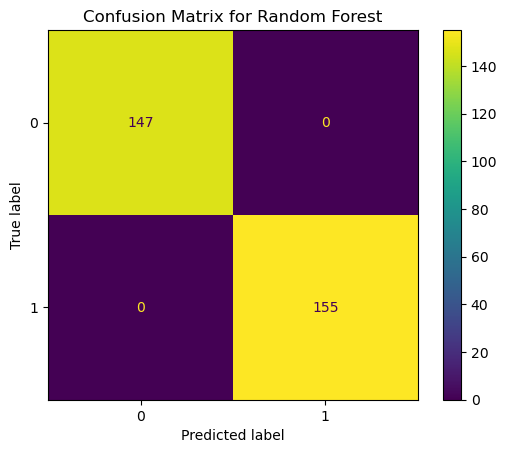

Confusion Matrix for Decision Tree:
[[147   0]
 [  0 155]]

Decision Tree Accuracy: 1.0
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       1.00      1.00      1.00       155

    accuracy                           1.00       302
   macro avg       1.00      1.00      1.00       302
weighted avg       1.00      1.00      1.00       302



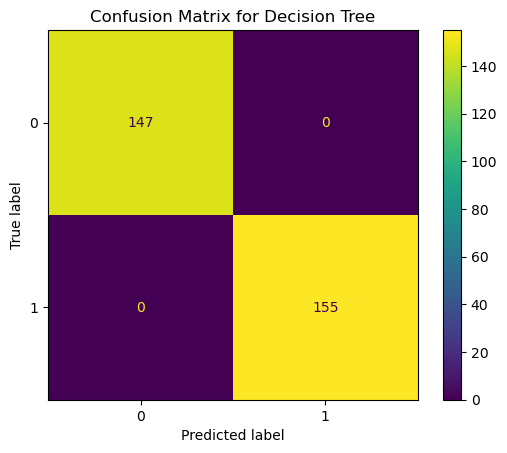

Confusion Matrix for SVM:
[[145   2]
 [  0 155]]

SVM Accuracy: 0.9933774834437086
SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       147
           1       0.99      1.00      0.99       155

    accuracy                           0.99       302
   macro avg       0.99      0.99      0.99       302
weighted avg       0.99      0.99      0.99       302



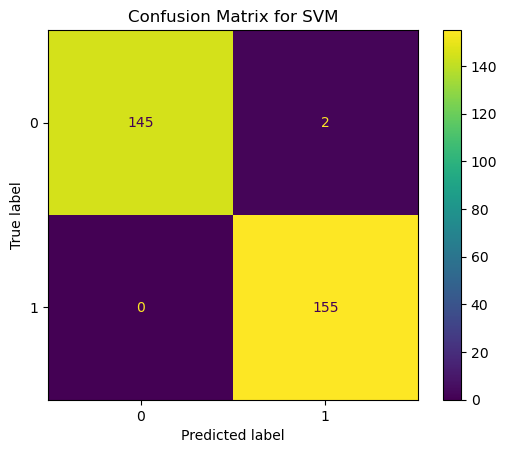

10/10 [==============================] - 0s 1ms/step
Confusion Matrix for Deep Learning:
[[147   0]
 [  0 155]]

Deep Learning Accuracy: 1.0
Deep Learning Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       1.00      1.00      1.00       155

    accuracy                           1.00       302
   macro avg       1.00      1.00      1.00       302
weighted avg       1.00      1.00      1.00       302



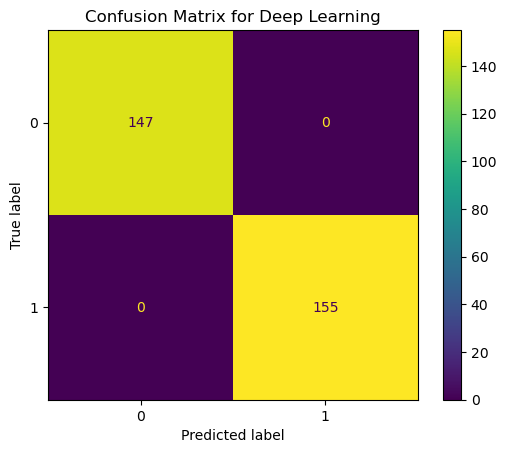

In [39]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    # Train Logistic Regression model
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)

    # Train Random Forest model
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)

    # Train Decision Tree model
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train, y_train)

    # Train SVM model
    svm_model = SVC()
    svm_model.fit(X_train, y_train)

    # Deep Learning model
    dl_model = Sequential()
    dl_model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
    dl_model.add(Dropout(0.5))
    dl_model.add(Dense(256, activation='relu'))
    dl_model.add(Dropout(0.5))
    dl_model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    dl_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    dl_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
    
    # Evaluate models
    models = {
        'Logistic Regression': logistic_model,
        'Random Forest': rf_model,
        'Decision Tree': dt_model,
        'SVM': svm_model,
        'Deep Learning': dl_model
    }
    
    best_model = None
    best_accuracy = 0

    for name, model in models.items():
        if name == 'Deep Learning':
            y_pred = (model.predict(X_test) > 0.5).astype("int32")
        else:
            y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        # Print the confusion matrix
        print(f"Confusion Matrix for {name}:\n{cm}\n")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
        
        print(f"{name} Accuracy: {accuracy}")
        print(f"{name} Classification Report:\n{report}")

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot()
        plt.title(f'Confusion Matrix for {name}')
        plt.show()

    return best_model

# Train and evaluate models
best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)

In [40]:
# Function to scrape and preprocess new articles
import requests
from bs4 import BeautifulSoup

def scrape_article(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract title and body text
        title = soup.title.string if soup.title else ''
        paragraphs = soup.find_all('p')
        content = ' '.join([para.get_text() for para in paragraphs])
        
        return title + ' ' + content
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return ''

def classify_text(text, model, vectorizer):
    cleaned_text = preprocess_text(text)
    features = vectorizer.transform([cleaned_text]).toarray()
    if isinstance(model, Sequential):
        prediction = (model.predict(features) > 0.5).astype("int32")
    else:
        prediction = model.predict(features)
    return "Real News" if prediction[0] == 1 else "Fake News"

In [41]:
# Interactive widget
import ipywidgets as widgets
from IPython.display import display, HTML

def setup_interactive_widget(best_model, vectorizer):
    # Input Section
    url_input = widgets.Text(
        value = '',
        placeholder = 'Enter news article URL',
        description = 'URL:',
        disabled = False
    )

    # Run Button
    run_button = widgets.Button(
        description = 'Check News',
        disabled = False,
        button_style = '',
        tooltip = 'Click to check if the news is fake',
        icon = 'check'
    )

    # Output Section
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            output.clear_output()
            
            url = url_input.value
            
            # Scrape the article and classify the content
            article_text = scrape_article(url)
            result = classify_text(article_text, best_model, vectorizer)
            
            display(HTML(f"<h3>Result: {result}</h3>"))
            display(HTML(f"<h4>Suggested Alternative Sources to check for authenticity:</h4>"))
            display(HTML("""
            <ul>
                <li><a href='https://www.bbc.com'>BBC News</a> - Known for its rigorous standards and global coverage.</li>
                <li><a href='https://www.reuters.com'>Reuters</a> - Renowned for its accuracy and objectivity in reporting.</li>
                <li><a href='https://www.apnews.com'>Associated Press (AP)</a> - A highly reliable news agency that provides factual news.</li>
                <li><a href='https://www.nytimes.com'>The New York Times</a> - Esteemed for its thorough investigative journalism and in-depth reporting.</li>
                <li><a href='https://www.washingtonpost.com'>The Washington Post</a> - Known for its comprehensive coverage and investigative reporting.</li>
                <li><a href='https://www.theguardian.com'>The Guardian</a> - Offers detailed international and investigative journalism.</li>
                <li><a href='https://www.wsj.com'>The Wall Street Journal</a> - Highly regarded for its financial and business news.</li>
                <li><a href='https://www.npr.org'>NPR (National Public Radio)</a> - Trusted for its balanced and in-depth news coverage.</li>
                <li><a href='https://www.bloomberg.com'>Bloomberg</a> - Respected for its financial news and economic analysis.</li>
                <li><a href='https://www.aljazeera.com'>Al Jazeera</a> - Known for its comprehensive coverage of international news.</li>
                <li><a href='https://www.economist.com'>The Economist</a> - Offers insightful analysis on global news and trends.</li>
                <li><a href='https://www.politico.com'>Politico</a> - Focuses on political news with in-depth reporting.</li>
                <li><a href='https://www.ft.com'>Financial Times</a> - Renowned for its financial and economic news coverage.</li>
                <li><a href='https://www.cnn.com'>CNN</a> - Provides extensive news coverage with a focus on breaking news.</li>
                <li><a href='https://www.cbsnews.com'>CBS News</a> - A trusted source for national and international news.</li>
            </ul>
            """))

    run_button.on_click(on_button_clicked)
    display(url_input, run_button, output)
    
# Setup the interactive widget
setup_interactive_widget(best_model, vectorizer)

Text(value='', description='URL:', placeholder='Enter news article URL')

Button(description='Check News', icon='check', style=ButtonStyle(), tooltip='Click to check if the news is fak…

Output()

### Conclusion

We successfully developed a comprehensive system to detect fake news by leveraging data scraping, preprocessing, and machine learning models. 

The final solution incorporates multiple classification algorithms, including logistic regression, random forest, decision tree, SVM, and deep learning, to ensure the best model is used for accurate predictions. 

An interactive widget was also created to enable users to input URLs and check the authenticity of news articles in real-time, providing alternative reliable sources for verification.

### Data Limitations and Challenges

While developing this system, we faced several data limitations and challenges. The initial step of data scraping was resource-intensive and time-consuming, as it required fetching large volumes of data from various news websites. 

Additionally, obtaining data involved relying on sources that list fake news websites and real news sources; Wikipedia's list of fake news websites and Politifact's guide to fake news websites. These sources were essential for compiling a dataset of fake and real news articles, which was crucial for training our models.

Despite these challenges, the final system demonstrates high accuracy in distinguishing between fake and real news, contributing to the fight against misinformation and helping users access reliable news sources.